<img src="./img/uomlogo.png" align="left"/><br><br>
# PHYS20762 - Project - Measuring Drop Spreading Law

Erik Germanovic<br>
University of Manchester  
January 2021

We first initialise our Python interpreter

In [21]:
# Initialisation
import string
from math import *
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import fsolve

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

![](./img/bee.png)
## Experimental Data

This is data that you are working with. It consists of a sequence of circle radii ($R$, measured in micrometers), obtained from image processing in three different experimental runs. The corresponding time ($t$, measured in seconds) was obtained from the image timestamps measured from the beginning of the experiment.     

In [22]:
# Radius data 
# experiment 1
radius_data1 = np.array([59.513027, 66.368389, 69.506166, 71.700852, 74.735925, 76.007795, 76.695256, 78.039551, 79.598386, 80.075493, 80.079624, 81.495363, 82.598934, 83.172805, 84.919440, 85.155809, 85.718415, 85.920147, 86.000243, 87.120934, 87.507943, 87.786892, 87.060409, 88.086562, 88.113767, 88.436448, 89.082172, 89.139957, 89.210538, 89.356928, 90.312937, 90.406557, 90.754907, 90.88941, 91.096467])
# experiment 2
radius_data2 = np.array([59.810888, 65.360919, 69.088934, 72.594631, 74.694093, 76.440186, 78.133942, 78.618537, 79.753566, 80.745559, 81.422723, 81.634563, 82.861597, 84.335873, 85.362055, 85.537714, 86.159399, 86.873675, 86.918131, 87.003533, 87.126402, 87.155440, 87.224911, 87.394479, 87.433936, 87.626938, 87.701465, 87.834029, 87.963874, 88.153147, 88.209880, 88.542036, 88.86527, 89.082038, 89.214132])
# experiment 3
radius_data3 = np.array([58.200029, 64.826353, 69.332991, 73.504694, 74.295033, 77.506575, 78.413291, 79.952682, 81.339708, 81.938359, 82.528196, 82.807452, 83.378999, 84.521468, 84.507216, 85.064265, 85.247146, 85.900079, 86.475709, 86.776052, 87.158810, 87.343755, 87.448085, 87.822712, 88.140434, 88.311032, 88.619312, 88.970210, 89.373613, 89.754486, 89.900430, 90.116608, 90.288358, 90.711677, 90.989783])
# time
time = np.array([0.500000, 1.000000, 1.500000, 2.000000, 2.500000, 3.000000, 3.500000, 4.000000, 4.500000, 5.000000, 5.500000, 6.000000, 6.500000, 7.000000, 7.500000, 8.000000, 8.500000, 9.000000, 9.500000, 10.000000, 10.500000, 11.000000, 11.500000, 12.000000, 12.500000, 13.000000, 13.500000, 14.000000, 14.500000, 15.000000, 15.500000, 16.000000, 16.500000, 17.000000, 17.500000])

Let's plot this data to see what it looks like:

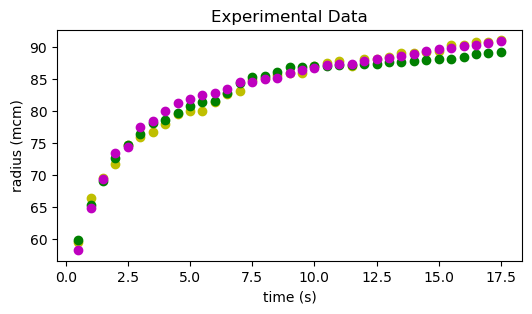

In [23]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
# plotting data from experimental runs 1-3:
plt.plot(time, radius_data1, "yo")
plt.plot(time, radius_data2, "go")
plt.plot(time, radius_data3, "mo")
# setting axis labels & figures 
plt.xlabel("time (s)")
plt.ylabel("radius (mcm)")
plt.title("Experimental Data")
# displaying the plot
plt.show()

Don't forget to find the errors on $R$ estimated from the three experimental runs.

![](./img/bee.png)
## Extracting Quantities Using Experimental Data

In order to find the spreading law: a relationship between the speed of the contact line ($U$) and the contact angle ($\theta$), we need to first find the quantities themselves, ie express $U$ and $\theta$ using $R=R(t)$. 

To speed of the contact line can be calculated using $U = \frac{dR}{dt} \approx \frac{R(t+\delta t)-R(t)}{\delta t}$, where $R(t+\delta t)$ and $R(t)$ are two sequential values of the footprint radii measured with time intreval $\delta t$ apart.  

To find the contact angle, we make the spherical cap approximation that allows us to calculate the height of the drop ($H$) from its volume ($V=7.6$ pL) and its footprint radius ($R$) which are known from experiments via relationship $V=\frac{\pi}{6}H(3R^2+H^2)$. The contact angle can then be found from $R$ and $H$ using $\theta = \frac{\pi}{2} - \mathrm{atan}\frac{R^2-H^2}{2HR}$. 

There are three sets of experimental data, so for each one of them a relationship $U=U(\theta)$ should be found.

In [24]:
def mean_and_error_function(data):
    # calculating average value and standard deviation between three data sets
    return np.mean(data, axis=0), np.std(data, axis=0)

def height_function(height, radius, volume):
    # evaluating relationship between height and radius of the drop
    return height**3 + 3 * radius**2 * height - volume * 6 / pi

def root_function(radius_array, volume):
    # calculating the roots of height function which correspond to the height of the drop
    height = np.zeros(radius_array.shape)
    for index, radius in enumerate(radius_array):
        root = fsolve(height_function, 1, args=(radius, volume))
        height[index] = root
    return height

def angle_function(radius, height):
    # calculating the contact angle of the drop
    return pi / 2 - np.arctan((radius**2 - height**2)/(2*height*radius))

def derivative_function(radius_difference, time_difference):
    # first order derivative with respect to time approximation for radius of the drop
    return radius_difference / time_difference

def line_speed_function(radius, time):
    # calculating contact line speed of the drop
    limit = len(radius)
    speed = np.array([])
    index = 0
    while index < limit - 1:
        speed = np.append(speed, derivative_function(radius[index + 1] - radius[index],
                                                     time[index + 1] - time[index]))
        index = index + 1
    return speed

# combining radius of three data sets
radius_combined = np.array([radius_data1, radius_data2, radius_data3])
radius_mean, radius_error = mean_and_error_function(radius_combined)

drop_volume = 7.6 * 10**(-15)

# height of the drop calculations
height_data1 = root_function(radius_data1 * 10**(-6), drop_volume)
height_data2 = root_function(radius_data2 * 10**(-6), drop_volume)
height_data3 = root_function(radius_data3 * 10**(-6), drop_volume)
height_combined = np.array([height_data1, height_data2, height_data3])
height_mean, height_error = mean_and_error_function(height_combined)

# Contact angle of the drop calculations
angle_data1 = angle_function(radius_data1 * 10**(-6), height_data1)
angle_data2 = angle_function(radius_data2 * 10**(-6), height_data2)
angle_data3 = angle_function(radius_data3 * 10**(-6), height_data3)
angle_combined = np.array([angle_data1, angle_data2, angle_data3])
angle_mean, angle_error = mean_and_error_function(angle_combined)

# Contact line speed of the drop calculations
line_speed1 = line_speed_function(radius_data1 * 10**(-6), time)
line_speed2 = line_speed_function(radius_data2 * 10**(-6), time)
line_speed3 = line_speed_function(radius_data3 * 10**(-6), time)
line_speed_combined = np.array([line_speed1, line_speed2, line_speed3])
line_speed_mean, line_speed_error = mean_and_error_function(line_speed_combined)

Let's plot these results to see what they look like:

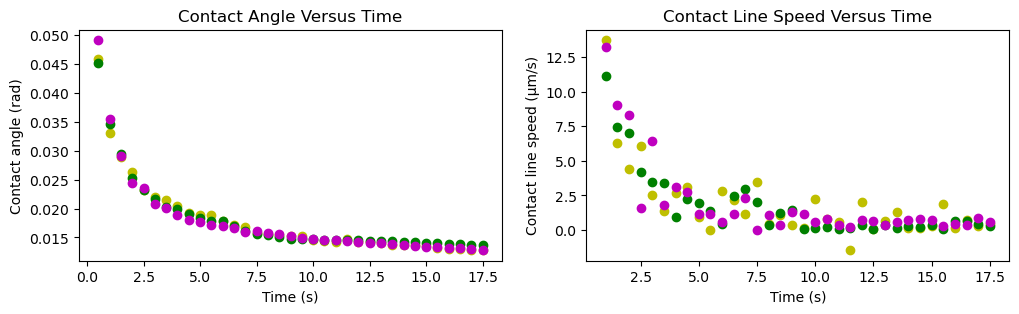

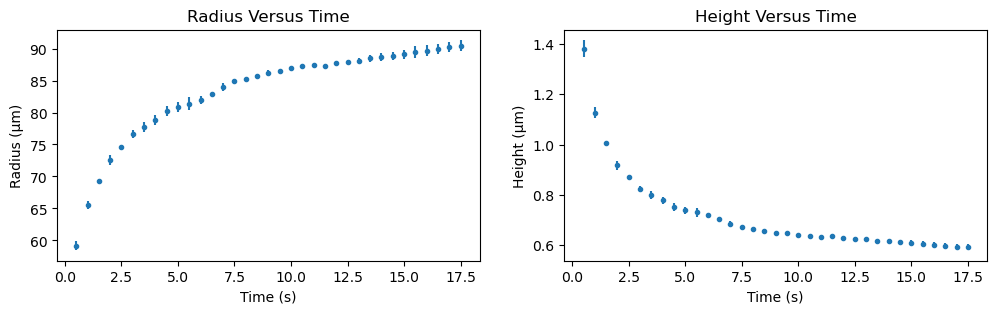

In [25]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (12,3)
fig, (ax1,ax2) = plt.subplots(1,2)

# plotting contact angle data from experimental runs 1-3:
ax1.plot(time, angle_data1, "yo")
ax1.plot(time, angle_data2, "go")
ax1.plot(time, angle_data3, "mo")

# setting axis labels & figures 
ax1.set(xlabel = 'Time (s)')
ax1.set(ylabel = 'Contact angle (rad)')
ax1.set_title('Contact Angle Versus Time')

# plotting contact line speed data from experimental runs 1-3:
ax2.plot(time[1:], line_speed1 * 10**6, "yo")
ax2.plot(time[1:], line_speed2 * 10**6, "go")
ax2.plot(time[1:], line_speed3 * 10**6, "mo")

# setting axis labels & figures 
ax2.set(xlabel = 'Time (s)')
ax2.set(ylabel = 'Contact line speed (µm/s)')
ax2.set_title('Contact Line Speed Versus Time')

plt.show()

# tweeking the figure size
fig, (ax1,ax2) = plt.subplots(1,2)

# plotting combined radius data from experimental runs 1-3:
ax1.errorbar(time, radius_mean, yerr=radius_error, fmt='.')

# setting axis labels & figures
ax1.set(xlabel = 'Time (s)')
ax1.set(ylabel = 'Radius (µm)')
ax1.set_title('Radius Versus Time')

# plotting combined height data from experimental runs 1-3:
ax2.errorbar(time, height_mean * 10**6, yerr=height_error * 10**6, fmt='.')

# setting axis labels & figures
ax2.set(xlabel = 'Time (s)')
ax2.set(ylabel = 'Height (µm)')
ax2.set_title('Height Versus Time')

plt.show()

The data $U=U(\theta)$ obtained for each of the three experimental runs is used to estimate the relationship between the mean contact line speed and the mean contact angle, and the corresponding errors on those. The result of this is plotted below. 

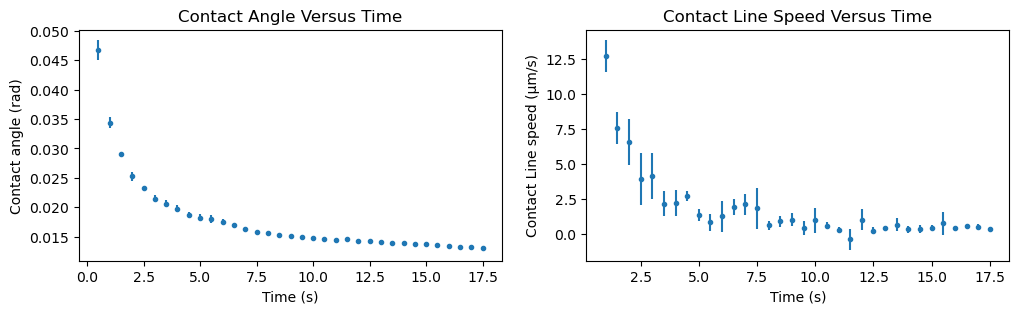

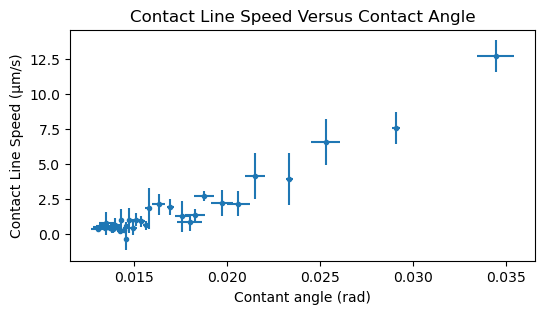

In [26]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (12,3)
fig, (ax1,ax2) = plt.subplots(1,2)

# plotting combined contact angle data from experimental runs 1-3:
ax1.errorbar(time, angle_mean, yerr=angle_error, fmt='.')

# setting axis labels & figures
ax1.set(xlabel = 'Time (s)')
ax1.set(ylabel = 'Contact angle (rad)')
ax1.set_title('Contact Angle Versus Time')

# plotting combined contact line speed data from experimental runs 1-3:
ax2.errorbar(time[1:], line_speed_mean * 10**6, yerr=line_speed_error * 10**6 , fmt='.')

# setting axis labels & figures
ax2.set(xlabel = 'Time (s)')
ax2.set(ylabel = 'Contact Line speed (µm/s)')
ax2.set_title('Contact Line Speed Versus Time')

plt.show()

# tweeking the figure size
plt.rcParams["figure.figsize"] = (6,3)

# plotting combined contact line speed data from experimental runs 1-3:
plt.errorbar(angle_mean[1:], line_speed_mean * 10**6, yerr=line_speed_error * 10**6, xerr=angle_error[1:], fmt='.')

# setting axis labels & figures
plt.xlabel("Contant angle (rad)")
plt.ylabel("Contact Line Speed (µm/s)")
plt.title("Contact Line Speed Versus Contact Angle")

plt.show()

![](./img/bee.png)
## Fitting Spreading Laws

We will now attemp to fit the Cox-Voinov law ($U = U_0( \theta^3 –  \theta_0^3)$) and the de Gennes law ($U = U_0( \theta^2 –  \theta_0^2)$) to the mean data $U=U(\theta)$ ploted above, where $U_0$ is termed the characteristic speed of the contact line, and $\theta_0$ is the equilibrium contact angle (when $\theta=\theta_0$, $U=0$). To avoid using nonlinear least square method, we will fit a straight line to the data $U=U(\theta^2)$ and $U=U(\theta^3)$. This will produce the values for the characteristic speed and the error on it $U_0^{fit} \pm \delta U_0^{fit}$, but it will not give the values of the equilibrium contact angle $\theta_0^{fit}$. Instead, $[U_0\theta^n]^{fit}$ with $n=2$ or $n=3$ will be found, from which $\theta_0$ can be comupted. The corresponding error $\delta\theta^{fit}$ should be found by propagating the errors from  $[U_0\theta^n]^{fit}$ and $U_0^{fit}$.

In [27]:
# finding best fit parameters and covariance matrices of Cox-Voinov and Gennes laws
gennes_coefficients, gennes_covariance = np.polyfit((angle_mean[1:])**2, line_speed_mean, 1, cov=True)
cox_coefficients, cox_covariance = np.polyfit((angle_mean[1:])**3, line_speed_mean, 1, cov=True)

# calculating U_0 and its error for Gennes fit
gennes_fit_speed = gennes_coefficients[0]
gennes_fit_speed_error = np.sqrt(gennes_covariance[0][0])

# calculating θ_0 and its error for Gennes fit
gennes_fit_angle = np.sqrt((-1) * gennes_coefficients[1] / gennes_fit_speed)
gennes_fit_angle_error = np.sqrt((-1/2 * (np.sqrt((-1) * gennes_coefficients[1]) / (gennes_fit_speed)**(3/2)
                                       * gennes_fit_speed_error))**2 + (1/2 * np.sqrt(1 / (
    gennes_fit_speed * (-1) * gennes_coefficients[1])) * np.sqrt(gennes_covariance[1][1]))**2)

# calculating U_0 and its error for Cox-Voinov fit
cox_fit_speed = cox_coefficients[0]
cox_fit_speed_error = np.sqrt(cox_covariance[0][0])

# calculating θ_0 and its error for Cox-Voinov fit
cox_fit_angle = (-1 * cox_coefficients[1] / cox_fit_speed)**(1/3)
cox_fit_angle_error = np.sqrt((1 / 3 * ((-1) * cox_coefficients[1])**(4/3) /
                               (cox_fit_speed)**(1/3) * np.sqrt(cox_covariance[1][1]))**2 + (
    1 / 3 * ((-1) * cox_coefficients[1])**(1/3) / (cox_fit_speed)**(4/3) * cox_fit_speed_error)**2)

# calculating fit values of contact line speed for Cox-Voinov and Gennes laws
angle_array = np.linspace(angle_mean[1], angle_mean[-1], 200)
cox_fit = np.polyval(cox_coefficients, (angle_array)**3)
gennes_fit = np.polyval(gennes_coefficients, (angle_array)**2)

Displaying the corresponding fits  

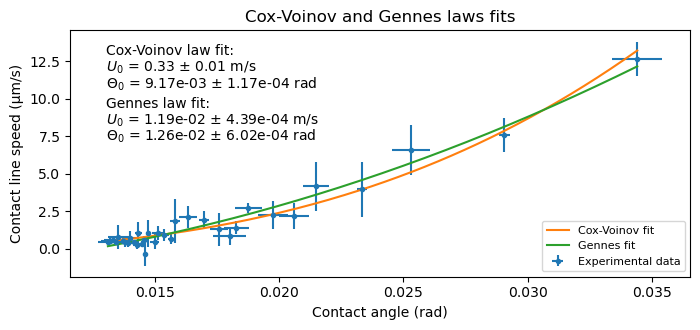

In [28]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (8,3.2)
plt.figure()

# plotting combined contact line speed data with Cox-Voinov and Gennes law fits
plt.errorbar(angle_mean[1:], line_speed_mean * 10**6, yerr=line_speed_error * 10**6,
             xerr=angle_error[1:], fmt='.', label='Experimental data')
plt.plot(angle_array, cox_fit * 10**6, label='Cox-Voinov fit')
plt.plot(angle_array, gennes_fit * 10**6, label='Gennes fit')

# providing additional information in the plot
plt.text(0.013, 12.9, 'Cox-Voinov law fit:')
plt.text(0.013, 11.8, '$U_0$ = {0:4.2f} ± {1:4.2f} m/s'.format(cox_fit_speed, cox_fit_speed_error))
plt.text(0.013, 10.7,'$\Theta_0$ = {0:4.2e} ± {1:4.2e} rad'.format(cox_fit_angle, cox_fit_angle_error))
plt.text(0.013, 9.4, 'Gennes law fit:')
plt.text(0.013, 8.3, '$U_0$ = {0:4.2e} ± {1:4.2e} m/s'.format(gennes_fit_speed, gennes_fit_speed_error))
plt.text(0.013, 7.2, '$\Theta_0$ = {0:4.2e} ± {1:4.2e} rad'.format(gennes_fit_angle, gennes_fit_angle_error))
plt.legend(loc='lower right', fontsize=8)

# setting axis labels & figures 
plt.xlabel("Contact angle (rad)")
plt.ylabel("Contact line speed (µm/s)")
plt.title("Cox-Voinov and Gennes laws fits")

plt.show()

![](./img/bee.png)
## Chi-squared Test

To establish which of the two laws better fits the data, we conduct the chi-squared test. The case is further strengthened using the residual plots. 

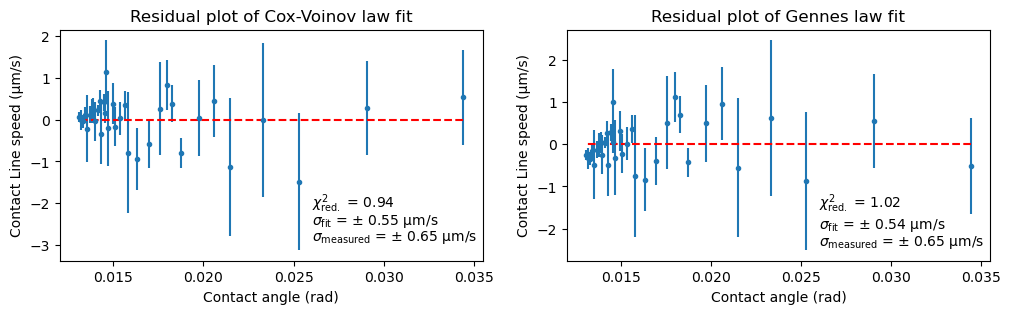

In [29]:
def chi_squared_function(fit_line_speed, contact_line_speed, error):
    # calculating chi-squared value of the fit
    return np.sum(((contact_line_speed - fit_line_speed) / error)**2)

def chi_squared_reduced(chi_squared, contact_line_speed, fit_coefficients):
    # calculating reduced chi-squared value of the fit
    return chi_squared/(len(contact_line_speed) - len(fit_coefficients))

def expected_error(fit_line_speed, contact_line_speed, fit_coefficients):
    # calculating expected error value of the fit
    return np.sqrt(1 / (len(contact_line_speed) - len(fit_coefficients)) * np.sum((contact_line_speed - fit_line_speed)**2))

# chi-squared calculations
cox_chi_squared = chi_squared_function(np.polyval(cox_coefficients, (angle_mean[1:])**3), line_speed_mean, line_speed_error)
gennes_chi_squared = chi_squared_function(np.polyval(gennes_coefficients,
                                                     (angle_mean[1:])**2), line_speed_mean, line_speed_error)

# reduced chi-squared calculations
cox_chi_reduced = chi_squared_reduced(cox_chi_squared, line_speed_mean, cox_coefficients)
gennes_chi_reduced = chi_squared_reduced(gennes_chi_squared, line_speed_mean, gennes_coefficients)

# expected error calculations
cox_expected_error = expected_error(np.polyval(cox_coefficients, (angle_mean[1:])**3), line_speed_mean, cox_coefficients)
gennes_expected_error = expected_error(np.polyval(gennes_coefficients,
                                                  (angle_mean[1:])**2), line_speed_mean, gennes_coefficients)

# tweeking the figure size
plt.rcParams["figure.figsize"] = (12,3)
fig, (ax1,ax2) = plt.subplots(1,2)

# residual plot of Cox-Voinov law fit
ax1.errorbar(angle_mean[1:], (np.polyval(cox_coefficients, (angle_mean[1:])**3) - line_speed_mean) * 10**6 ,
             yerr=line_speed_error * 10**6, fmt='.')
ax1.plot(np.linspace(angle_mean[1], angle_mean[-1], 50), np.zeros(50), color='red', linestyle='dashed')

# setting axis labels & figures
ax1.set(xlabel = 'Contact angle (rad)')
ax1.set(ylabel = 'Contact Line speed (µm/s)')
ax1.set_title('Residual plot of Cox-Voinov law fit')
ax1.text(0.026, -2.1, '$\chi^2_{{\mathrm{{red.}}}}$ = {:3.2f}'.format(cox_chi_reduced))
ax1.text(0.026, -2.5, '$\sigma_{{\mathrm{{fit}}}}$ = ± {:3.2f} µm/s'.format(cox_expected_error * 10**6))
ax1.text(0.026, -2.9, '$\sigma_{{\mathrm{{measured}}}}$ = ± {:3.2f} µm/s'.format(np.mean(line_speed_error) * 10**6))

# residual plot of Gennes law fit
ax2.errorbar(angle_mean[1:], (np.polyval(gennes_coefficients, (angle_mean[1:])**2) - line_speed_mean) * 10**6 ,
             yerr=line_speed_error * 10**6, fmt='.')
ax2.plot(np.linspace(angle_mean[1], angle_mean[-1], 50), np.zeros(50), color='red', linestyle='dashed')

# setting axis labels & figures
ax2.set(xlabel = 'Contact angle (rad)')
ax2.set(ylabel = 'Contact Line speed (µm/s)')
ax2.set_title('Residual plot of Gennes law fit')
ax2.text(0.026, -1.5, '$\chi^2_{{\mathrm{{red.}}}}$ = {:3.2f}'.format(gennes_chi_reduced))
ax2.text(0.026, -2, '$\sigma_{{\mathrm{{fit}}}}$ = ± {:3.2f} µm/s'.format(gennes_expected_error * 10**6))
ax2.text(0.026, -2.4, '$\sigma_{{\mathrm{{measured}}}}$ = ± {:3.2f} µm/s'.format(np.mean(line_speed_error) * 10**6))

plt.show()

![](./img/bee.png)
## Drop Spreading Law Is

The results of the chi-squared analysis suggest that the "de Gennes" law is a better fit for the behaviour of the spreading drop because the corresponding reduced chi-squared value of the fit is closer to 1 than it is for Cox-Voinov law. However, the values of reduced chi-squared are simillar, suggesting that both laws can be suitable. Calculated expected errors from the fits suggest that values of errors are slighlty more suitable to Cox-Voinov law. Looking at residual plots of the fits we can see that de Gennes law fit is slightly more evenly distributed around 0 in positive and negative values. Moreover, most of the points cross 0 value line, further approving that de Gennes law is a better fit.
Theoretical formula implies that contact angle of the drop can vary from 0 to $\frac{\pi}{2}$. However, obtained results suggest that the footprint radius is much bigger than the height of the drop. This results in significantly lower contact angles, and true variation from 0 to 2 degrees.
The obtained characteristic speed of de Gennes fit is of the appropriate order of magnitude. Even though characteristic speed is much higher than the speed values obtained from experiments, during calculation of speed it is multiplied by $( \theta^2 –  \theta_0^2)$ which in our case is << 1. Characteristic speed obtained from Cox-Voinov fit is too big and not of the appropriate order of magnitude.
The calculated errors are one or two orders of magnitude lower than the calculated values. This is appropriate since it gives an error in the range of 3 to 5 %.
Lastly, Cox-Voinov law does not work when omitting the first value of contact angle data and using the last value instead. It results in a negative contact angle which is not physically possible in our case.

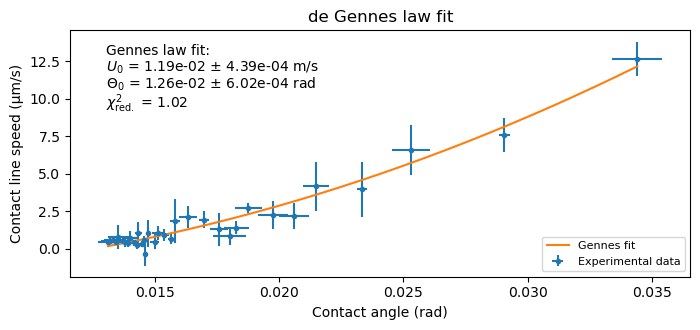

In [30]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (8,3.2)
plt.figure()

# plotting combined contact line speed data with Gennes law fit
plt.errorbar(angle_mean[1:], line_speed_mean * 10**6, yerr=line_speed_error * 10**6,
             xerr=angle_error[1:], fmt='.', label='Experimental data')
plt.plot(angle_array, gennes_fit * 10**6, label='Gennes fit')

# providing additional information in the plot
plt.text(0.013, 12.9, 'Gennes law fit:')
plt.text(0.013, 11.8, '$U_0$ = {0:4.2e} ± {1:4.2e} m/s'.format(gennes_fit_speed, gennes_fit_speed_error))
plt.text(0.013, 10.7, '$\Theta_0$ = {0:4.2e} ± {1:4.2e} rad'.format(gennes_fit_angle, gennes_fit_angle_error))
plt.text(0.013, 9.4, '$\chi^2_{{\mathrm{{red.}}}}$ = {:3.2f}'.format(gennes_chi_reduced))
plt.legend(loc='lower right', fontsize=8)

# setting axis labels & figures 
plt.xlabel("Contact angle (rad)")
plt.ylabel("Contact line speed (µm/s)")
plt.title("de Gennes law fit")

plt.show()

![](./img/bee.png)
## Stretch yourself section

This section is to be populated by you entirely 